In [134]:
import pandas as pd
import re
import numpy as np
import os

In [135]:
df = pd.read_csv('../data/raw-data/googleplaystore.csv')

## Data Exploration


In [136]:
df.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

In [137]:
df.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [138]:
df.nunique()

App               9660
Category            34
Rating              40
Reviews           6002
Size               462
Installs            22
Type                 3
Price               93
Content Rating       6
Genres             120
Last Updated      1378
Current Ver       2832
Android Ver         33
dtype: int64

## Data Cleaning and transforming

#### Remove duplicates

In [139]:
df[df.duplicated(keep='first')]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
229,Quick PDF Scanner + OCR FREE,BUSINESS,4.2,80805,Varies with device,"5,000,000+",Free,0,Everyone,Business,"February 26, 2018",Varies with device,4.0.3 and up
236,Box,BUSINESS,4.2,159872,Varies with device,"10,000,000+",Free,0,Everyone,Business,"July 31, 2018",Varies with device,Varies with device
239,Google My Business,BUSINESS,4.4,70991,Varies with device,"5,000,000+",Free,0,Everyone,Business,"July 24, 2018",2.19.0.204537701,4.4 and up
256,ZOOM Cloud Meetings,BUSINESS,4.4,31614,37M,"10,000,000+",Free,0,Everyone,Business,"July 20, 2018",4.1.28165.0716,4.0 and up
261,join.me - Simple Meetings,BUSINESS,4.0,6989,Varies with device,"1,000,000+",Free,0,Everyone,Business,"July 16, 2018",4.3.0.508,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8643,Wunderlist: To-Do List & Tasks,PRODUCTIVITY,4.6,404610,Varies with device,"10,000,000+",Free,0,Everyone,Productivity,"April 6, 2018",Varies with device,Varies with device
8654,"TickTick: To Do List with Reminder, Day Planner",PRODUCTIVITY,4.6,25370,Varies with device,"1,000,000+",Free,0,Everyone,Productivity,"August 6, 2018",Varies with device,Varies with device
8658,ColorNote Notepad Notes,PRODUCTIVITY,4.6,2401017,Varies with device,"100,000,000+",Free,0,Everyone,Productivity,"June 27, 2018",Varies with device,Varies with device
10049,Airway Ex - Intubate. Anesthetize. Train.,MEDICAL,4.3,123,86M,"10,000+",Free,0,Everyone,Medical,"June 1, 2018",0.6.88,5.0 and up


#### Reviews

* while preprocessing the Review column, we found  that there text values in the column

* by viewing this we can say that the row has shifted value and cannot be used, so we will drop it

In [140]:

df.reset_index(inplace=True)
df[df['Reviews'] == '3.0M']

,index,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [141]:
df = df.drop(10472, axis=0)

In [142]:
df['Reviews'] = df['Reviews'].apply(lambda x: int(x))

#### Installs

* Remove "+" & "," and convert to int type

In [143]:
df['Installs'] = df['Installs'].apply(lambda x: int(x.replace('+', '').replace(',', '')))

### Size

* Remove "M" & "K" and convert KB size to MB size

In [144]:
df['Size'] = df['Size'].apply(lambda x: str(x).replace('M', '').replace(',', ''))

In [145]:
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)

* while preprocessing the Size column, we found that there are some values with 'Varies with device' which is not a valid value, so will convert them into NAN 

In [146]:
df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', '0') if 'Varies with device' in str(x) else x)

In [147]:
df['Size'] = df['Size'].apply(lambda x: float(x) * 1_000_000)

* convert 'Varies with device' to NaN

In [148]:
df['Size'].describe()

count    1.084000e+04
mean     1.815209e+07
std      2.217061e+07
min      0.000000e+00
25%      2.600000e+06
50%      9.200000e+06
75%      2.600000e+07
max      1.000000e+08
Name: Size, dtype: float64

In [149]:
df['Size'].isnull().sum()

0

### Price

* Remove "$" sign and convert to float

In [150]:
df['Price'] = df['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))
df['Price'] = df['Price'].apply(lambda x: float(x))

In [151]:
# df['Price'].isnull().sum()
df['Price'].describe()

count    10840.000000
mean         1.027368
std         15.949703
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        400.000000
Name: Price, dtype: float64

### Dates

In [152]:
df['Last Updated'] = pd.to_datetime(df['Last Updated'])
df["year"] = df["Last Updated"].dt.year
df["month"] = df["Last Updated"].dt.month

In [153]:
df['year'].min(), df['year'].max()  

(2010, 2018)

## Transform

### Number of apps and average rating by Category 


In [154]:
# groups = df.groupby('Category').filter(lambda x: len(x) > 300).reset_index()

# # calculate the average rating
# average_rating = np.nanmean(groups['Rating'])

# # create a list of categories
# categories = list(set(groups['Category']))

# #prepare data for each category
# category_data = []
# for category in categories:
#     category_dict = {
#         'Category': category,
#         'Average_Rating': np.nanmean(groups.loc[groups['Category'] == category]['Rating']),
#         'Number_of_Apps': len(groups.loc[groups['Category'] == category]),
#     }
#     category_data.append(category_dict)


# df_category_summary = pd.DataFrame(category_data)

# df_category_summary


## Analysis


In [155]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import plotly
# connected=True means it will download the latest version of plotly javascript library.
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.figure_factory as ff
# import cufflinks as cf
import streamlit as st


### Type


In [156]:
analysis_df = df.copy()

In [157]:
analysis_df.columns

Index(['index', 'App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs',
       'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated',
       'Current Ver', 'Android Ver', 'year', 'month'],
      dtype='object')

In [158]:
number_of_apps_in_category = analysis_df['Category'].value_counts().sort_values(ascending=True)

data = [go.Pie(
        labels = number_of_apps_in_category.index,
        values = number_of_apps_in_category.values,
        hoverinfo = 'label+value'
    
)]

plotly.offline.iplot(data, filename='active_category')

In [159]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10840 entries, 0 to 10840
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           10840 non-null  int64         
 1   App             10840 non-null  object        
 2   Category        10840 non-null  object        
 3   Rating          9366 non-null   float64       
 4   Reviews         10840 non-null  int64         
 5   Size            10840 non-null  float64       
 6   Installs        10840 non-null  int64         
 7   Type            10839 non-null  object        
 8   Price           10840 non-null  float64       
 9   Content Rating  10840 non-null  object        
 10  Genres          10840 non-null  object        
 11  Last Updated    10840 non-null  datetime64[ns]
 12  Current Ver     10832 non-null  object        
 13  Android Ver     10838 non-null  object        
 14  year            10840 non-null  int32         
 15  month  

In [160]:
# COUNT ANALYSIS_DF['PRICE] OUNTS VALUE WITH PRICE GREATER THAN 100
analysis_df[analysis_df['year'] > 2017]

,index,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,year,month
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000.0,10000,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,2018,1
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,2018,1
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000.0,5000000,Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up,2018,8
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000.0,50000000,Free,0.0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up,2018,6
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000.0,100000,Free,0.0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up,2018,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10826,10826,Frim: get new friends on local chat rooms,SOCIAL,4.0,88486,0.0,5000000,Free,0.0,Mature 17+,Social,2018-03-23,Varies with device,Varies with device,2018,3
10827,10827,Fr Agnel Ambarnath,FAMILY,4.2,117,13000000.0,5000,Free,0.0,Everyone,Education,2018-06-13,2.0.20,4.0.3 and up,2018,6
10831,10831,payermonstationnement.fr,MAPS_AND_NAVIGATION,NaN,38,9800000.0,5000,Free,0.0,Everyone,Maps & Navigation,2018-06-13,2.0.148.0,4.0 and up,2018,6
10837,10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3600000.0,100,Free,0.0,Everyone,Education,2018-07-06,1.0,4.1 and up,2018,7


In [161]:
data = [go.Histogram(
        x = df.Rating,
        xbins = {'start': 1, 'size': 0.1, 'end' :5}
)]

print('Average app rating = ', np.mean(df['Rating']))
plotly.offline.iplot(data, filename='overall_rating_distribution')

Average app rating =  4.191757420456972


F_onewayResult(statistic=17.458034645387226, pvalue=7.792539500402071e-29)

The p-value is extremely small, hence we reject the null hypothesis in favor of the alternate hypothesis.



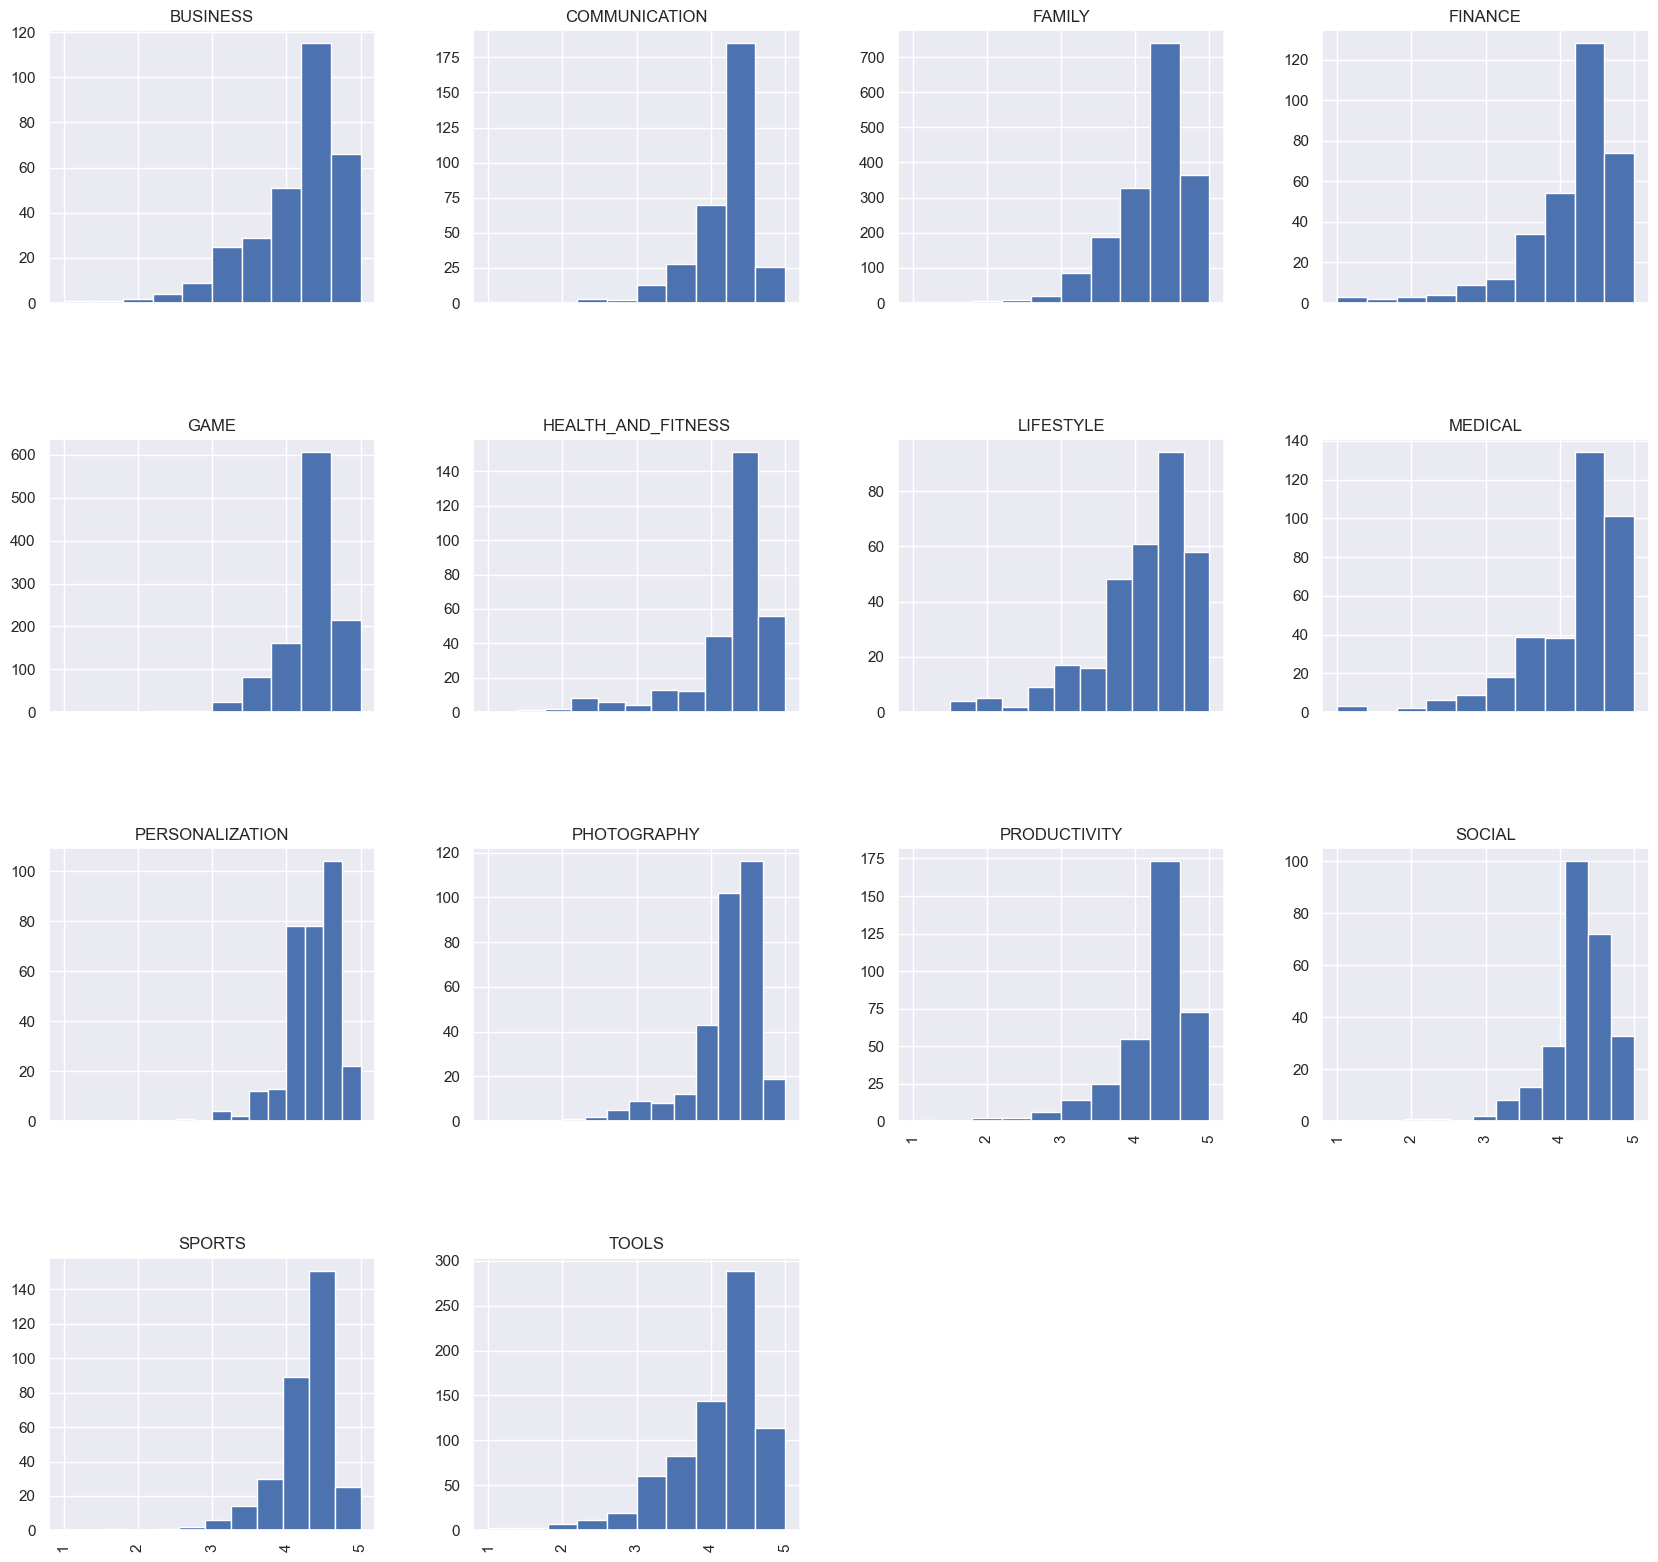

In [162]:
import scipy.stats as stats
f = stats.f_oneway(df.loc[df.Category == 'BUSINESS']['Rating'].dropna(), 
               df.loc[df.Category == 'FAMILY']['Rating'].dropna(),
               df.loc[df.Category == 'GAME']['Rating'].dropna(),
               df.loc[df.Category == 'PERSONALIZATION']['Rating'].dropna(),
               df.loc[df.Category == 'LIFESTYLE']['Rating'].dropna(),
               df.loc[df.Category == 'FINANCE']['Rating'].dropna(),
               df.loc[df.Category == 'EDUCATION']['Rating'].dropna(),
               df.loc[df.Category == 'MEDICAL']['Rating'].dropna(),
               df.loc[df.Category == 'TOOLS']['Rating'].dropna(),
               df.loc[df.Category == 'PRODUCTIVITY']['Rating'].dropna()
              )

print(f)
print('\nThe p-value is extremely small, hence we reject the null hypothesis in favor of the alternate hypothesis.\n')
#temp = df.loc[df.Category.isin(['BUSINESS', 'DATING'])]

groups = df.groupby('Category').filter(lambda x: len(x) > 286).reset_index()
array = groups['Rating'].hist(by=groups['Category'], sharex=True, figsize=(20,20))

In [163]:
analysis_df.to_csv('../data/analysis-data/dashboard.csv', index=False)

In [164]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10840 entries, 0 to 10840
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           10840 non-null  int64         
 1   App             10840 non-null  object        
 2   Category        10840 non-null  object        
 3   Rating          9366 non-null   float64       
 4   Reviews         10840 non-null  int64         
 5   Size            10840 non-null  float64       
 6   Installs        10840 non-null  int64         
 7   Type            10839 non-null  object        
 8   Price           10840 non-null  float64       
 9   Content Rating  10840 non-null  object        
 10  Genres          10840 non-null  object        
 11  Last Updated    10840 non-null  datetime64[ns]
 12  Current Ver     10832 non-null  object        
 13  Android Ver     10838 non-null  object        
 14  year            10840 non-null  int32         
 15  month  

In [166]:
analysis_df['Price'].unique()

array([  0.  ,   4.99,   3.99,   6.99,   1.49,   2.99,   7.99,   5.99,
         3.49,   1.99,   9.99,   7.49,   0.99,   9.  ,   5.49,  10.  ,
        24.99,  11.99,  79.99,  16.99,  14.99,   1.  ,  29.99,  12.99,
         2.49,  10.99,   1.5 ,  19.99,  15.99,  33.99,  74.99,  39.99,
         3.95,   4.49,   1.7 ,   8.99,   2.  ,   3.88,  25.99, 399.99,
        17.99, 400.  ,   3.02,   1.76,   4.84,   4.77,   1.61,   2.5 ,
         1.59,   6.49,   1.29,   5.  ,  13.99, 299.99, 379.99,  37.99,
        18.99, 389.99,  19.9 ,   8.49,   1.75,  14.  ,   4.85,  46.99,
       109.99, 154.99,   3.08,   2.59,   4.8 ,   1.96,  19.4 ,   3.9 ,
         4.59,  15.46,   3.04,   4.29,   2.6 ,   3.28,   4.6 ,  28.99,
         2.95,   2.9 ,   1.97, 200.  ,  89.99,   2.56,  30.99,   3.61,
       394.99,   1.26,   1.2 ,   1.04])

In [170]:
analysis_df['Price'].mean()

1.027368081180812